In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img


import PIL

import scipy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, add, Embedding, Dropout, LSTM, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


tf.random.set_seed(0)

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'application',
 'data',
 'descriptions.txt',
 'model_file.h5',
 'output',
 'Pretrained VGG16.ipynb',
 'Training.ipynb',
 'training_check_pt']

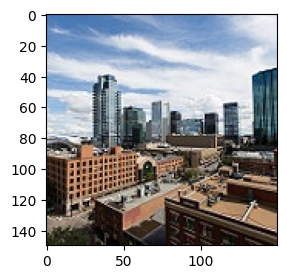

In [4]:
plt.figure(figsize=(3, 3))
test_img = plt.imread('data/seg_train/seg_train/buildings/10006.jpg')
plt.imshow(test_img)

In [5]:
test_img.shape

(150, 150, 3)

## Data Preparation

Since our training data are a set of images distributed accors differents classes in the training folder we can use the splitfloders function which splits a given folder with a ratio chosen .

In our case we are going to split the training set into a training and validation one

In [6]:
train_folder = 'D:\PROJECTS\AI Projects\Image Classifier\data\seg_train\seg_train'
test_folder = 'D:\PROJECTS\AI Projects\Image Classifier\data\seg_test\seg_test'
pred_folder = 'D:\PROJECTS\AI Projects\Image Classifier\data\seg_pred\seg_pred'

In [7]:
# del splitfolders

In [8]:
# %%time
# splitfolders.ratio(train_folder, output="output", seed=1337, ratio=(0.8, 0.2))

In [9]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', validation_split = 0.1
)

test_gen = ImageDataGenerator(rescale = 1.0 / 255)

In [10]:
train_generator = datagen.flow_from_directory(
    train_folder, subset = 'training',
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)
validation_generator = datagen.flow_from_directory(
    train_folder, subset = 'validation',
    batch_size = 8,
    target_size = (150,150),
    class_mode = "categorical"
)

test_generator = test_gen.flow_from_directory(
        test_folder,
        target_size=(150, 150),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
class_ = train_generator.class_indices
class_names = [x for x in class_.keys()]
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [35]:
input_size = 150
model = Sequential([
    Conv2D(input_shape=(input_size,input_size,3),filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),
    
    Conv2D(filters= 64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(),
    
    Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(),
    
    Conv2D(filters = 128,kernel_size=(3,3),activation='relu',padding = 'same'),
    MaxPool2D(),
    
    Conv2D(filters = 256,kernel_size=(3,3),activation='relu',padding = 'same'),
    MaxPool2D(),
    
    Flatten(name='flatten'),
    Dense(6, activation = 'softmax')
    
])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 64)      

In [41]:
checkpoint_path = "D:/PROJECTS/AI Projects/Image Classifier/training_check_pt/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
# model.fit(train_images, 
#           train_labels,  
#           epochs=10,
#           validation_data=(test_images, test_labels),
#           callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [45]:
%%time
with tf.device('/GPU:0'):
    history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                        validation_steps = 2810 // 32,
                        epochs = 10,
                        validation_data = validation_generator,
                       callbacks=[cp_callback])

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8271
Epoch 1: saving model to D:/PROJECTS/AI Projects/Image Classifier/training_check_pt\cp.ckpt
350/350 [==============================] - 59s 167ms/step - loss: 0.4795 - accuracy: 0.8271 - val_loss: 0.5307 - val_accuracy: 0.8132
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8304
Epoch 2: saving model to D:/PROJECTS/AI Projects/Image Classifier/training_check_pt\cp.ckpt
350/350 [==============================] - 56s 159ms/step - loss: 0.4650 - accuracy: 0.8304 - val_loss: 0.5161 - val_accuracy: 0.8290
Epoch 3/10
350/350 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8429
Epoch 3: saving model to D:/PROJECTS/AI Projects/Image Classifier/training_check_pt\cp.ckpt
350/350 [==============================] - 56s 160ms/step - loss: 0.4451 - accuracy: 0.8429 - val_loss: 0.4373 - val_accuracy: 0.8592
Epoch 4/10
350/350 [==============

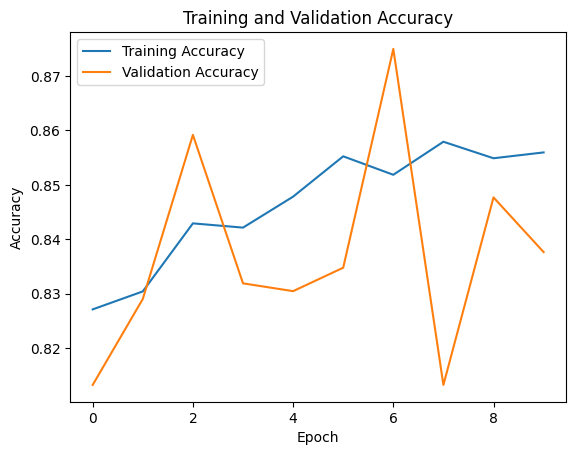

In [46]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [47]:
evaluation_results = model.evaluate(test_generator)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

3000/3000 [==============================] - 20s 7ms/step - loss: 0.4512 - accuracy: 0.8480
Test Loss: 0.4511626362800598
Test Accuracy: 0.8479999899864197


In [69]:
def prediction(image_path, model):
    # Image Loading
    im = image.load_img(image_path, target_size=(150, 150))
    X = image.img_to_array(im)
    X = X/ 255
    X = X.reshape(1, 150, 150, 3)
    score = model.predict(X)
    class_ = train_generator.class_indices
    class_names = [x for x in class_.keys()]
    # print(class_names)
    print("")

    plt.figure(figsize=(3,3))
    g = plt.imread(image_path)
    plt.title(f' Image is classified as {class_names[np.argmax(score)]}')
    # return print()
    plt.imshow(g)

In [46]:
# X/255

In [47]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

10004.jpg
1/1 [==============================] - 0s 22ms/step

10005.jpg
1/1 [==============================] - 0s 21ms/step

10012.jpg
1/1 [==============================] - 0s 23ms/step

10013.jpg
1/1 [==============================] - 0s 24ms/step

10017.jpg
1/1 [==============================] - 0s 24ms/step

10021.jpg
1/1 [==============================] - 0s 27ms/step

1003.jpg
1/1 [==============================] - 0s 25ms/step

10034.jpg
1/1 [==============================] - 0s 22ms/step

10038.jpg
1/1 [==============================] - 0s 22ms/step



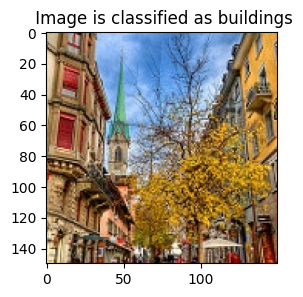

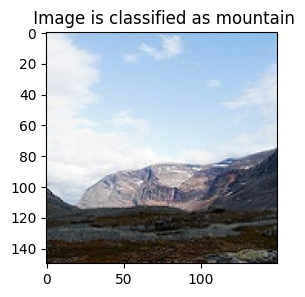

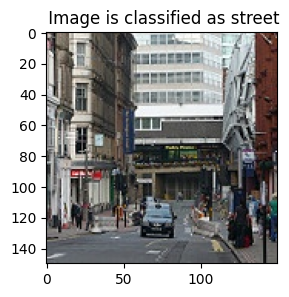

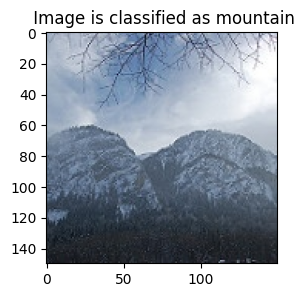

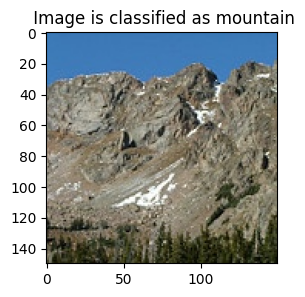

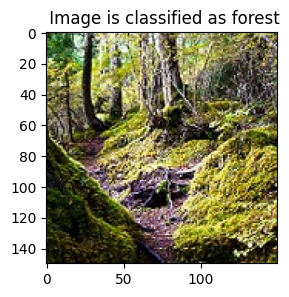

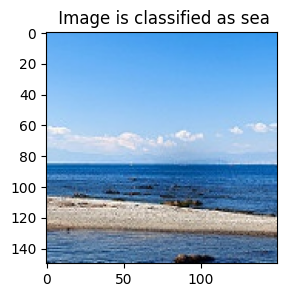

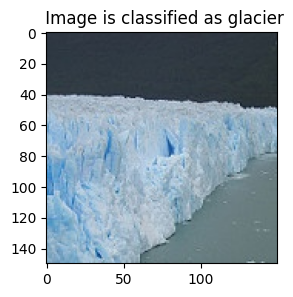

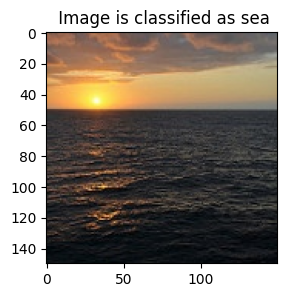

In [70]:
count = 1
for i in os.listdir('/PROJECTS/AI Projects/Image Classifier/data/seg_pred/seg_pred'):
    print(i)
    count+= 1
    prediction('/PROJECTS/AI Projects/Image Classifier/data/seg_pred/seg_pred/'+i, test_model)
    if count==10:
        break

## Saving Model to checkpoint

In [48]:
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=7))

In [50]:
checkpoint_dir

'D:/PROJECTS/AI Projects/Image Classifier/training_check_pt'

In [51]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [52]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'D:/PROJECTS/AI Projects/Image Classifier/training_check_pt\\cp.ckpt'

## Model Loading from Checkpoint

In [56]:
# Define a simple sequential model
def create_model():
    input_size = 150
    model = Sequential([
        Conv2D(input_shape=(input_size,input_size,3),filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'),
        MaxPool2D(),
        
        Conv2D(filters= 64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPool2D(),
        
        Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPool2D(),
        
        Conv2D(filters = 128,kernel_size=(3,3),activation='relu',padding = 'same'),
        MaxPool2D(),
        
        Conv2D(filters = 256,kernel_size=(3,3),activation='relu',padding = 'same'),
        MaxPool2D(),
        
        Flatten(name='flatten'),
        Dense(6, activation = 'softmax')
        
    ])
    # model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    return model

In [58]:
# Create a basic model instance
model_test = create_model()

# Display the model's architecture
model_test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 18, 18, 64)      

In [59]:
# # Create a new model instance
# model = create_model()

# Load the previously saved weights
model_test.load_weights(latest)

# Re-evaluate the model
evaluation_results = model_test.evaluate(test_generator)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

3000/3000 [==============================] - 22s 7ms/step - loss: 0.4512 - accuracy: 0.8480
Test Loss: 0.4511626362800598
Test Accuracy: 0.8479999899864197


## Saving entire model to .h5 format

In [62]:
# The '.h5' extension indicates that the model should be saved to HDF5.
model_test.save('model_file.h5')

## Loading from .h5 file

In [12]:
test_model = load_model('model_file.h5')

In [14]:
# Re-evaluate the model
evaluation_results = test_model.evaluate(test_generator)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

3000/3000 [==============================] - 20s 6ms/step - loss: 0.4512 - accuracy: 0.8480
Test Loss: 0.4511626064777374
Test Accuracy: 0.8479999899864197


In [ ]:
test_model.predict()

In [61]:
image_path = 'data/seg_pred/seg_pred/10388.jpg'

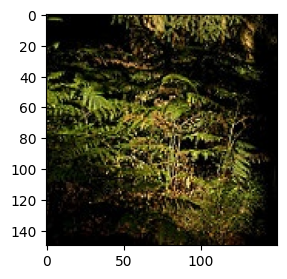

In [62]:
plt.figure(figsize=(3, 3))
test_img = plt.imread(image_path)
plt.imshow(test_img)

In [71]:
im = image.load_img(image_path, target_size=(150, 150))
X = image.img_to_array(im)
X = X/ 255
# X = X.reshape(1, 150, 150, 3)

In [74]:
np.expand_dims(X, axis = 0).shape

(1, 150, 150, 3)

In [64]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [65]:
test_model.predict(X)

1/1 [==============================] - 0s 24ms/step


array([[2.0811452e-02, 9.6177143e-01, 9.0035154e-03, 6.1332190e-04,
        1.2212977e-04, 7.6782019e-03]], dtype=float32)